In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [3]:
%ls

 Balanced_I_hotel_dataset_final.ipynb     LSTM_stop_final_lstm_ablation.ipynb
 Balanced_II_hotel_dataset_final.ipynb    optuna_test/
 booking_time_final_original/             output/
 Business_hotel_dataset_final.ipynb       output_other_dataset/
 clustered_test.pkl                       Preprocess_data_dunnhumby.ipynb
 copy_optuna_test/                        Preprocess_data_full_hotel_dataset_final.ipynb
 data_analysis/                           price_tft/
 Leisure_hotel_dataset_final.ipynb        RandomForestRegressor_final_dunnhumby.ipynb
 lightning_logs/                          RandomForestRegressor_final.ipynb
 LSTM_final_dunnhumby_FINAL.ipynb        'Readme file.gdoc'
 LSTM_next_final_ablation.ipynb           TFT_creation_to_creation_final.ipynb
 LSTM_next_final.ipynb                    tft.pkl
 LSTM_next_final_no_lstm_ablation.ipynb   TFT_target_price_final.ipynb
 LSTM_stop_final_ablation.ipynb           Trained_models/
 LSTM_stop_final.ipynb                    Transformer_enc

Imported libraries

In [4]:
!pip install pytorch_forecasting
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 830.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_ext

In [5]:

import os
import pandas as pd
from datetime import date, timedelta, datetime
import numpy as np
import lightning.pytorch as pl


import math
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import plotly.graph_objects as go

import matplotlib.pyplot as plt


To ignore warnings:

In [6]:
import warnings
warnings.filterwarnings('ignore')

Add whether the creation date was done during the vacation of the state or not

In [ ]:
def get_start_end_col_names(lan):
  if lan == "DE" or lan=='AT' or lan=="LI":
    return "Beginn", "Ende"
  elif lan == "FR":
    return "Début", "Fin"
  elif lan =="IT":
    return "Inizio", "Fine"

def get_dt_tuple(x, language):
  start_col, end_col = get_start_end_col_names(language)
  start_date = [int(date) for date in x[start_col].split(".")]
  if not pd.isnull(x[end_col]):
    end_date = [int(date) for date in x[end_col].strip(" *").split(".")]
  else:
    end_date = start_date
  return (date(start_date[2], start_date[1], start_date[0]),
          date(end_date[2], end_date[1], end_date[0]))


def process_vacations(dir):
  filenames = [file for file in os.listdir(dir) if file.endswith('_vacancies.csv')]
  vacation_dict = {}
  for file in filenames:
    state = file.split("_")[0]
    state_df = pd.read_csv(os.path.join(dir, file))
    vacation_dict[state] = state_df.apply(lambda x: get_dt_tuple(x, language=state[:2]), axis=1).to_list()
  return vacation_dict

result_dict = process_vacations('output/1_vacations/')


In [ ]:

def date_is_vacation_arrival(row):
  state_vacations = result_dict[row["state"]]
  for i in state_vacations:
    if pd.Timestamp(i[0]) <= pd.Timestamp(row["arrival"]) <= pd.Timestamp(i[1]):
      return 1
  return 0

def date_is_vacation_creation(row):
  state_vacations = result_dict[row["state"]]
  for i in state_vacations:
    if pd.Timestamp(i[0]) <= pd.Timestamp(row["creation_date"]) <= pd.Timestamp(i[1]):
      return 1
  return 0

# df_hotel["vacation"] = df_hotel.apply(date_is_vacation, axis=1)

Add whether the creation date was done during the holiday of the state or not

In [ ]:
def get_only_dates(x):
  while True:
    if x[1].__contains__("."):
      dates = [int(date) for date in x[1].split(".")]
      return date(dates[2], dates[1], dates[0])
    else:
      break

def process_holidays(dir):
  filenames = [file for file in os.listdir(dir) if file.endswith('_holidays.csv')]
  holiday_dict = {}
  for file in filenames:
    state = file.split("_")[0]
    state_df_holiday = pd.read_csv(os.path.join(dir, file))
    list_state = state_df_holiday.apply(get_only_dates, axis = 1).to_list()
    while None in list_state:
      list_state.remove(None)
    holiday_dict[state] = list_state
  return holiday_dict

dict_holiday = process_holidays('output/1_vacations/')

def date_is_holiday_arrival(row):
  state_holiday = dict_holiday[row["state"]]
  for i in state_holiday:
    if pd.Timestamp(i) == pd.Timestamp(row["arrival"]):
      return 1
  return 0

def date_is_holiday_creation(row):
  state_holiday = dict_holiday[row["state"]]
  for i in state_holiday:
    if pd.Timestamp(i) == pd.Timestamp(row["creation_date"]):
      return 1
  return 0
# df_hotel["holiday"] = df_hotel.apply(date_is_holiday, axis=1)

**General data preprocessing**

In [ ]:
#There are 801327 nan values from the variable booking_channel but that variable will not be used yet so those rows will not be disregarded
run = True
if run == True:
  def preprocess_hotel_data(df_hotel):
      df_hotel["children"] = df_hotel["infants"] + df_hotel["kids"]
      df_hotel["price_p_night"] = df_hotel["price"]/df_hotel["nights"]
      df_hotel["ratio_child_adult"] = df_hotel["children"] / df_hotel["adults"]
      df_hotel = df_hotel[(df_hotel["rooms"] >= 1) & (df_hotel["rooms"] < 60)]
      df_hotel = df_hotel[(df_hotel["price"] < 70000) & (df_hotel["price"] >= 0)]
      df_hotel = df_hotel[(df_hotel["lodging"] < 50000) & (df_hotel["lodging"] >= 0)]
      df_hotel = df_hotel[(df_hotel["beauty"] < 50000) & (df_hotel["beauty"] >= 0)]
      df_hotel = df_hotel[(df_hotel["restaurant"] < 50000) & (df_hotel["restaurant"] >= 0)]
      df_hotel = df_hotel[(df_hotel["extras"] < 50000) & (df_hotel["extras"] >= 0)]
      df_hotel = df_hotel[(df_hotel["ratio_child_adult"] <= 3) & (df_hotel["ratio_child_adult"] >= 0)]
      df_hotel = df_hotel[~df_hotel["state"].str.startswith("CH")]
      df_hotel = df_hotel[~(df_hotel["state"] == 'FR-J')]
      df_hotel = df_hotel[~(df_hotel["state"] == 'FR-U')]
      df_hotel = df_hotel[~(df_hotel["state"] == 'FR-R')]
      df_hotel = df_hotel[~(df_hotel["state"] == 'FR-COR')]
      df_hotel = df_hotel[~(df_hotel["state"] == 'LI-08')]
      date_format = "%Y/%m/%d"
      df_hotel["departure"] = pd.to_datetime(df_hotel["departure"], format = date_format)
      df_hotel["arrival"] = pd.to_datetime(df_hotel["arrival"], format = date_format)
      df_hotel["days"] = (df_hotel["departure"] - df_hotel["arrival"]).dt.days

      # df_hotel = df_hotel[(df_hotel["nights"] < 30) & (df_hotel["nights"] > 0)] Not needed
      df_hotel = df_hotel.drop(columns = ["ratio_child_adult"])
      return df_hotel

  path = 'output/3_booking_data_updated/'
  filenames = [file for file in os.listdir(path) if file.endswith('.feather')]
  # df_guests = pd.concat([pd.read_feather(path + file) for file in filenames], ignore_index=True)
  # df_guests["children"] = df_guests["infants"] + df_guests["kids"]
  # df_guests["ratio_child_adult"] = df_guests["children"] / df_guests["adults"]

  for i in filenames:
      df_hotel = pd.read_feather(path + i)
      # df_hotel = df_hotel.apply(preprocess_hotel_data, axis = 1)
      df_hotel = preprocess_hotel_data(df_hotel)
      df_hotel["vacation_arrival_date"] = df_hotel.apply(date_is_vacation_arrival, axis=1)
      df_hotel["holiday_arrival_date"] = df_hotel.apply(date_is_holiday_arrival, axis=1)
      df_hotel["vacation_creation_date"] = df_hotel.apply(date_is_vacation_creation, axis=1)
      df_hotel["holiday_creation_date"] = df_hotel.apply(date_is_holiday_creation, axis=1)
      df_hotel["weekday_arrival_date"] = df_hotel["arrival"].apply(lambda x: x.weekday())
      df_hotel["weekday_creation_date"] = df_hotel["creation_date"].apply(lambda x: x.weekday())
      weekend = lambda x: 0 if x < 5 else 1
      df_hotel["weekend_arrival_date"] = df_hotel["weekday_arrival_date"].map(weekend)
      df_hotel["weekend_creation_date"] = df_hotel["weekday_creation_date"].map(weekend)
      # df_all_hotels['early_booker'] = df_all_hotels.apply(lambda row : early(row), axis=1)
      # df_all_hotels['average_booker'] = df_all_hotels.apply(lambda row : average(row), axis=1)
      # df_all_hotels['late_booker'] = df_all_hotels.apply(lambda row : late(row), axis=1)
      # print(df_hotel)
      if 'level_0' in df_hotel.columns:
        df_hotel = df_hotel.drop("level_0", axis = "columns")
      df_hotel = df_hotel.reset_index()
      print(i)
      directory_save = 'output/0_preprocessed_data_updated/'
      df_hotel.to_feather(directory_save + i)

aida_helvetia_hotel_reservations.feather


KeyboardInterrupt: ignored

**Use data from a certain timeframe: 1-1-2012 until 1-1-2018**

In [ ]:
def filter_dates(lowest_date, highest_date, path):
  filenames = [file for file in os.listdir(path) if file.endswith('.feather')]
  for i in filenames:
    df_hotel = pd.read_feather(path+i)
    result = False
    min_date = df_hotel["creation_date"].min()
    max_date = df_hotel["creation_date"].max()
    if min_date <= lowest_date and max_date >= highest_date:
      result = True
    if result == True:
      filtered_df_hotel = df_hotel.loc[(df_hotel['creation_date'] >= lowest_date)
                      & (df_hotel['creation_date'] < highest_date)]
      # filtered_df_hotel = filtered_df_hotel.drop(columns = "level_0")
      filtered_df_hotel = filtered_df_hotel.reset_index()
      directory_save = 'output/9_data_within_timeframe_updated/'
      filtered_df_hotel.to_feather(directory_save + i)
filter_dates(datetime(2012,1,1), datetime(2018, 1,1), 'output/0_preprocessed_data_updated/')

Clustering the hotels

In [ ]:
df_all_hotels = pd.DataFrame()
path = 'output/9_data_within_timeframe_updated/'
filenames = [file for file in os.listdir(path) if file.endswith('.feather')]
for i in filenames:
  df_hotel = pd.read_feather(path + i)
  df_all_hotels = pd.concat([df_all_hotels, df_hotel])

In [ ]:
# grouped_df = df_all_hotels.groupby("guest_id").agg({"guest_id" : "size", "nights" : "mean", "children" : "mean", "adults" : "mean", "rooms" : "mean", "vacation_arrival_date" : "mean",	"holiday_arrival_date" : "mean",	"weekday_arrival_date" : "mean",	"weekend_arrival_date" : "mean",	"vacation_creation_date" : "mean",	"holiday_creation_date" : "mean",	"weekday_creation_date" : "mean",	"weekend_creation_date" : "mean"}).rename(columns={"guest_id" : "amount_visits"})
grouped_df = df_all_hotels.groupby("guest_id").agg({"guest_id" : "size", "nights" : "mean", "children" : "mean", "adults" : "mean", "rooms" : "mean", "vacation_arrival_date" : "mean",	"holiday_arrival_date" : "mean",	"weekend_arrival_date" : "mean",	"vacation_creation_date" : "mean",	"holiday_creation_date" : "mean",	"weekend_creation_date" : "mean"}).rename(columns={"guest_id" : "amount_visits"})
index_list = grouped_df.index.tolist()

In [ ]:
X = grouped_df
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
kmeans = KMeans(
        n_clusters= 4, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
kmeans.fit(X)
# X_inverse = scaler.inverse_transform(X)
# clusters=pd.DataFrame(X_inverse,columns=df_all_hotels.drop("guest_id",axis=1).columns)
clusters=pd.DataFrame(X,columns=grouped_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=600,width=1200)
fig4.update_layout(font = dict(family = '<b>variable</b>', size = 20)

)
fig4.show()

In [ ]:
clusters["guest_id"] = index_list
guest_label_dict = pd.Series(clusters.label.values,index=clusters.guest_id).to_dict()
df_all_hotels['labels'] = df_all_hotels['guest_id'].map(guest_label_dict)
df_value_counts = df_all_hotels["guest_id"].value_counts().to_frame()
df_value_counts["count_guests"] = df_value_counts["guest_id"]
df_value_counts = df_value_counts.drop(["guest_id"], axis = 1)
df_value_counts["guest_id"] = df_value_counts.index
dict_values = pd.Series(df_value_counts.count_guests.values, index = df_value_counts.guest_id).to_dict()
df_all_hotels["amount_times_visited"] = df_all_hotels["guest_id"].map(dict_values)

In [ ]:
def add_column_crea_next_crea(df):
  result = df.copy()
  result = result.sort_values(by = "creation_date")
  result = pd.concat(g for _, g in result.groupby("guest_id"))
  result = result.drop(columns = ["level_0"])
  result = result.reset_index()
  result["creation_to_new_creation"] = -10
  for i in range(len(result)-1):
    if result["amount_times_visited"][i] > 1:
      if result["guest_id"][i] == result["guest_id"][i + 1]:
        if (result["creation_date"][i+1] - result["creation_date"][i]).days < 1095: #Try a bit with different thresholds for this to see how model performs.
          result["creation_to_new_creation"][i] = (result["creation_date"][i+1] - result["creation_date"][i]).days
        else:
          result["creation_to_new_creation"][i] = pd.Timedelta(days = -100).days
      else:
        result["creation_to_new_creation"][i] = pd.Timedelta(days = -1000).days
  # result.loc[result_non_unique.index[-1], "arrival_to_new_creation"] = pd.Timedelta(days = -999).days
  return result

df_all_hotels = add_column_crea_next_crea(df_all_hotels)



*   creation to creation days = 0: More than one booking is made on the same day
*   creation to creation days = -10: Less than 2 amount of times visited
*   creation to creation days = -100: next booking more than 3 years later
*   creation to creation days = -1000: last booking

In [ ]:
# df_hotel_sorted = df_all_hotels.set_index(["guest_id"]).sort_index()
df_all_hotels_remv = df_all_hotels[df_all_hotels.creation_to_new_creation != -100]
df_all_hotels_remv = df_all_hotels_remv[df_all_hotels_remv.creation_to_new_creation != -10]
df_all_hotels_remv = df_all_hotels_remv[df_all_hotels_remv.creation_to_new_creation != 0]
# df_all_hotels_remv = df_all_hotels_remv[df_all_hotels_remv.creation_to_new_creation != -1000]

In [ ]:
list_index = []
# df_hotel_sorted_0 = df_all_hotels_0.set_index(["guest_id"]).sort_index()
for guest in df_all_hotels_remv["guest_id"].unique():
  num_times_guest = len(df_all_hotels_remv[df_all_hotels_remv["guest_id"] == guest])
  t_index_column = list(range(1, num_times_guest + 1))
  list_index.append(t_index_column)
list_index_new = [item for sublist in list_index for item in sublist]
df_all_hotels_remv["time_index"] = list_index_new

In [ ]:
df_all_hotels_remv = df_all_hotels_remv.drop("level_0", axis = 1)
df_all_hotels_remv = df_all_hotels_remv.reset_index()

In [ ]:
df_value_counts = df_all_hotels_remv["guest_id"].value_counts().to_frame()
df_value_counts["count_guests"] = df_value_counts["guest_id"]
df_value_counts = df_value_counts.drop(["guest_id"], axis = 1)
df_value_counts["guest_id"] = df_value_counts.index
dict_values = pd.Series(df_value_counts.count_guests.values, index = df_value_counts.guest_id).to_dict()
df_all_hotels_remv["amount_times_visited"] = df_all_hotels_remv["guest_id"].map(dict_values)

In [ ]:
df_all_hotels_remv = df_all_hotels_remv[df_all_hotels_remv["amount_times_visited"] != 1]

In [ ]:
df_all_hotels_remv = df_all_hotels_remv.drop("level_0", axis = "columns")
df_all_hotels_remv = df_all_hotels_remv.reset_index()

In [ ]:
df_all_hotels_remv.to_feather('output/10_selected_guest_data/df_all_hotels_remv_updated_withminus1000_dif_clus')

In [7]:
df_all_hotels_remv = pd.read_feather('output/10_selected_guest_data/df_all_hotels_remv_updated_withminus1000_dif_clus')

In [8]:
grouped_amount = df_all_hotels_remv.groupby("guest_id").agg({"amount_times_visited" : "mean"})

In [9]:
grouped_amount["amount_times_visited"].describe()

count    44481.000000
mean         3.271734
std          3.264758
min          2.000000
25%          2.000000
50%          2.000000
75%          4.000000
max        418.000000
Name: amount_times_visited, dtype: float64

In [10]:
df_all_hotels_remv = df_all_hotels_remv.drop(["level_0", "index", "state", "birthday", "reservation_id", "arrival", "departure", "booking_channel", "hotel_name"], axis = 1)
df_all_hotels_remv = df_all_hotels_remv.set_index(["guest_id", "time_index"])

In [11]:
dates = pd.date_range(start=df_all_hotels_remv["creation_date"].dt.date.min(), end= df_all_hotels_remv["creation_date"].dt.date.max())
lst_values = list(range(1, len(dates) + 1))
dict_dates = {dates[i]: lst_values[i] for i in range(len(dates))}

In [12]:
df_all_hotels_remv["time_index_with_creation_date"] = df_all_hotels_remv["creation_date"].dt.date.map(dict_dates)
df_all_hotels_remv = df_all_hotels_remv.drop(["creation_date"], axis = 1)

In [13]:
df_copy = df_all_hotels_remv.copy()

In [14]:
X = df_copy.drop(["creation_to_new_creation", "group_type", "vacation_type"], axis = 1)
y = df_copy["creation_to_new_creation"]

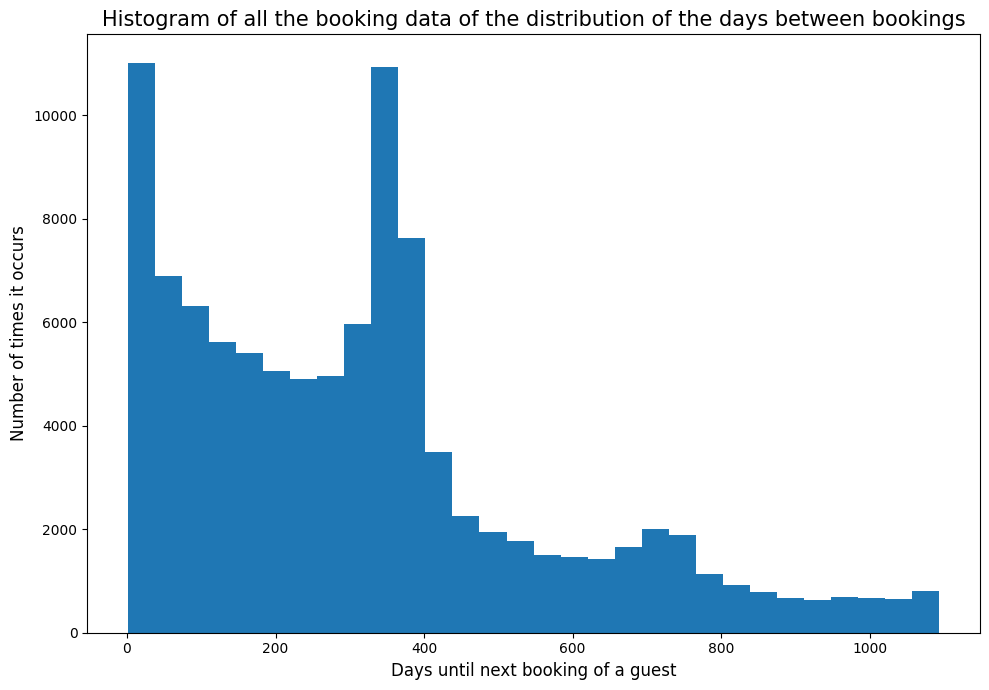

In [24]:
y_without_1000 = y[y > 0]
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)

axs.hist(y_without_1000, bins = 30)
plt.title("Histogram of all the booking data of the distribution of the days between bookings", size = 15)
plt.xlabel("Days until next booking of a guest", size = 12)
plt.ylabel("Number of times it occurs", size = 12)
# plt.xticks(ticks = 20)
# Show plot
plt.show()

In [ ]:
y.to_csv('output/10_selected_guest_data/y_original_data')

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output/10_selected_guest_data/df_original_data')

In [ ]:
scaler = RobustScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output/10_selected_guest_data/df_original_data_robustscaler')

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output/10_selected_guest_data/df_original_data_standardscaler')